In [1]:
from primeGraph import Graph, START, END
from primeGraph.models import GraphState
from primeGraph.buffer import History, LastValue, Incremental
from pydantic import BaseModel, Field
from openai import OpenAI
import instructor
from IPython.display import Image

from dotenv import load_dotenv

# assumes you have a local .env file with OPENAI_API_KEY set
load_dotenv()

# loading openai client
client = instructor.from_openai(OpenAI())


# Chatbot


### Sync


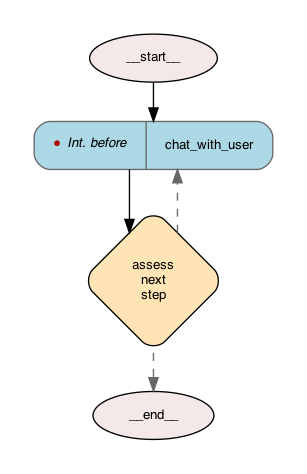

In [2]:
class ChatbotState(GraphState):
    chat_history: History[dict[str, str]]
    user_wants_to_exit: LastValue[bool] = Field(default=False)

class ChatbotResponse(BaseModel):
    chat_message: str
    user_requested_to_quit: bool = Field(description="returns true if user is requesting to quit the chat")


chatbot_state = ChatbotState(chat_history=[], user_wants_to_exit=False)
chatbot_graph = Graph(state=chatbot_state, verbose=False)

@chatbot_graph.node(interrupt="before")
def chat_with_user(state):

    # user input will be inserted directly into the chat_history on the state
    # Extract structured data from natural language
    try:
        res = client.chat.completions.create(
            model="gpt-4o-mini",
            response_model=ChatbotResponse,
            messages=state.chat_history,
        ) 
        print(res.chat_message)
        return {"chat_history": {"role": "assistant", "content": res.chat_message}, 
                "user_wants_to_exit": res.user_requested_to_quit}
        
    except Exception as e:
        raise e
    

@chatbot_graph.node()
def assess_next_step(state):
    if state.user_wants_to_exit:
        return END
    return "chat_with_user"

chatbot_graph.add_edge(START, "chat_with_user")
chatbot_graph.add_router_edge("chat_with_user", "assess_next_step")

chatbot_graph.compile()
Image(chatbot_graph.visualize(transparent=False).pipe(format='png'))


In [3]:
chatbot_graph.start()

def add_user_message(message: str):
    chatbot_state.chat_history.append({"role": "user", "content": message})

while not chatbot_state.user_wants_to_exit:
    
    user_input = input("Your message: ")
    print(f"You: {user_input}")
    add_user_message(user_input)

    chatbot_graph.resume()

print("Bye")


You: Hello
Hello! How can I assist you today?
You: Nothing special, just playing around
That sounds fun! If you have any questions or topics you'd like to explore while you're playing around, feel free to ask!
You: ok, bye! 
ok, bye!
Bye
